# Template for Spectral and temporal modifications Lab


*From R. Badeau and G. Richard (with help from P. Vernhet), MAJ:2019*

**python version : 3.6**

Adjustments made by: SOUZA PINTO MEDEIROS, Gabriel

In [30]:
import os, sys, wave, struct

import numpy as np
import pyaudio
import pandas as pd
import matplotlib.pyplot as plt

from copy import deepcopy
from math import ceil
import scipy.signal as sig

import pyaudio
import IPython.display as ipd

## Functions

In [2]:
def load_sound(file):
    return wave.open(file, 'rb')


def play_sound(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()

def nextpow2(x):
    assert x>0
    p = ceil(np.log2(x))
    x_ = 2**p
    assert 2**(p-1) < x <= x_
    return p, x_

def period(x, Fs, Pmin=1/300, Pmax=1/80, seuil=0.7) :
    # [P,voiced] = period(x,Fs,Pmin,Pmax,seuil);
    # If voiced = 1, P is the period signal x expressed in number of samples
    # If voiced = 0, P is equal to 10ms.Fs

    x = x - np.mean(x)
    N = len(x)

    Nmin = np.ceil(Pmin*Fs).astype(int)
    Nmax = 1 + np.floor(Pmax*Fs).astype(int)
    Nmax = np.min([Nmax,N])

    _, Nfft = nextpow2(2*N-1)
    X = np.fft.fft(x, n=Nfft)
    S = X * np.conj(X) / N
    r = np.real(np.fft.ifft(S))

    rmax = np.max(r[Nmin:Nmax])
    I = np.argmax(r[Nmin:Nmax])
    P = I+Nmin
    corr = (rmax/r[0]) * (N/(N-P))
    voiced = corr > seuil
    if not(voiced):
        P = np.round(10e-3*Fs)

    return P,voiced

## 0 - Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [3]:
data_path = os.getcwd()
filename = 'aeiou.wav'
sound = os.path.join(data_path, filename) 

### **Using wave**

In [4]:
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=11025, nframes=59964, comptype='NONE', compname='not compressed')


In [5]:
play = False
if play :
    play_sound(sound) 

In [6]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)

In [7]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

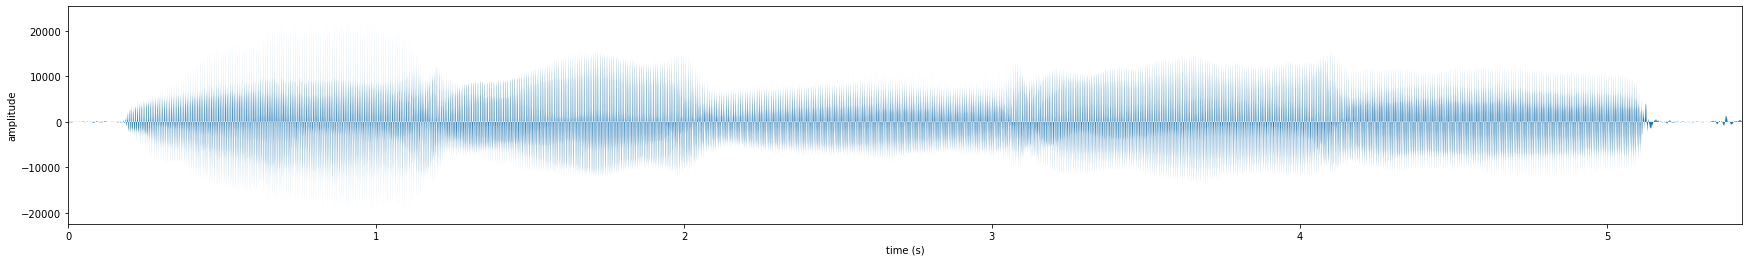

In [8]:
plot_sound(x, times)

## 1 Extraction of the Analysis Marks

To extract the analysis marks I just followed the instructions given. However, I didn't follow the suggestion of recursivity, because I couldn't envision what could be gained by implementing it recursively.

In [9]:
def analysisPitchMarks (x, Fs):
    P, t, voiced = [], [], []
    P.append(0.01*Fs)
    t.append(0)
    voiced.append(False)
    i = 1
    
    start = int(t[i-1])
    end = int(t[i-1] + 2.5*P[i-1])
    
    N = len(x)
    
    while(end<N):
        auxP, auxVoiced = period(x[start:end], Fs)
        P.append(auxP)
        voiced.append(auxVoiced)
        t.append(t[i-1]+P[i])
        i += 1
        start = int(t[i-1])
        end = int(t[i-1] + 2.5*P[i-1])
        
    return np.stack((t, voiced, P))
        

In [10]:
A = analysisPitchMarks(x, Fs)

## 2.1 Signal Sythesis
The implementation followed the suggested one without implementing recursivity.

In [11]:
B = np.stack((A[0, :], np.arange(len(A[1, :]))))

In [61]:
def Synthesis(s, Fs, A, B):
    t_end = B[0, -1]
    P_end = A[2, int(B[1, -1])]
    
    y = np.zeros(int(t_end + P_end))
    
    for k in range(len(B[1])):
        x_start = int(A[0, int(B[1, k])]- A[2, int(B[1, k])])
        x_end = int(A[0, int(B[1, k])] + A[2, int(B[1, k])])
        x = s[x_start:x_end]
        x = x*sig.hann(len(x))
        y[int(B[0, k]-A[2, int(B[1, k])]):int(B[0, k]+A[2, int(B[1, k])])] += x
    return y  

In [62]:
y = Synthesis(x, Fs, A, B)

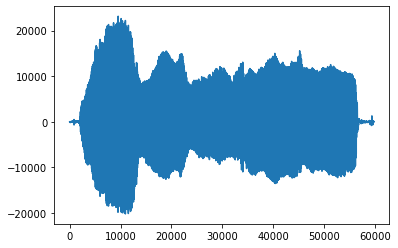

In [63]:
plt.plot(y)
ipd.Audio(y, rate=Fs)

## 2.2 Modification of the Temporal Scale
This implementation was once more very similar to the suggested one, but without recursivity as well. Also, I added an initialization for $n(k)$ because arrays in python start from 0. Also, when the instructions are followed rigorously $n(k)$ and $t_s(k)$ have different sizes, so I had to discard the final instance of $n(k)$.

In [99]:
def ChangeTimeScale(alpha, A, Fs):
    ts, nk = [], []
    ts.append(1)
    nk.append(0)
    nk.append(1)
    N = len(A[2])
    k=1
    while(nk[k]<N):
        ts.append(ts[k-1]+A[2, int(np.floor(nk[k]))])
        nk.append(nk[k]+1/alpha)
        k+=1
    return np.stack((ts, nk[:-1]))
    

In [111]:
B_time = ChangeTimeScale(0.5, A, Fs)
y_time = Synthesis(x, Fs, A, B_time)
ipd.Audio(y_time, rate=Fs)

## 2.3 Modification on the spectral scale
The problems that arose in 2.3 were the same that arose in 2.2, and the solutions that were implemented were the same as well.

In [101]:
def ChangePitchScale(beta, A, Fs):
    ts, nk = [], []
    ts.append(1)
    nk.append(0)
    nk.append(1)
    N = len(A[2])
    k=1
    while(nk[k]<N):
        if (A[1, int(np.floor(nk[k]))]):
            scale = 1/beta
        else:
            scale = 1

        ts.append(ts[k-1]+scale*A[2, int(np.floor(nk[k]))])
        nk.append(nk[k]+scale)
        k+=1
    return np.stack((ts, nk[:-1]))
    

In [112]:
B_pitch = ChangePitchScale(2, A, Fs)
y_pitch = Synthesis(x, Fs, A, B_pitch)
ipd.Audio(y_pitch, rate=Fs)

## 2.4 Joint modification of the spectral and temporal scales
The problems that arose in 2.4 were the same that arose in 2.2, and the solutions that were implemented were the same as well.

In [109]:
def ChangeBothScales(alpha, beta, A, Fs):
    ts, nk = [], []
    ts.append(1)
    nk.append(0)
    nk.append(1)
    N = len(A[2])
    k=1
    while(nk[k]<N):
        if (A[1, int(np.floor(nk[k]))]):
            scale = 1/beta
        else:
            scale = 1

        ts.append(ts[k-1]+scale*A[2, int(np.floor(nk[k]))])
        nk.append(nk[k]+scale/alpha)
        k+=1
    return np.stack((ts, nk[:-1]))
    

In [114]:
B_both = ChangeBothScales(0.5, 2, A, Fs)
y_both = Synthesis(x, Fs, A, B_both)
ipd.Audio(y_both, rate=Fs)